# Import

## Import Libraries & Data

In [5]:
import platform
import re
sys = re.match(r"([^\-]+)", platform.platform())

In [ ]:
match sys:
  case "Linux":
    #Mount Drive
    from google.colab import drive
    drive.mount('/content/drive')
    #Import sys, os, and module from shared drive
    MODULE_DIR = "/content/drive/MyDrive/DiabetesML" #module file path
    import sys, os
    assert "formula.py" in os.listdir(MODULE_DIR)
    sys.path.append(MODULE_DIR)
  case "Windows":
    MODULE_DIR = "diabetes.csv"

In [ ]:
#Import Libraries
import importlib
import formula as fm
import pandas as pd
import numpy as np
import statsmodels.api as sm
import random as rand
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import OrdinalEncoder #The only difference w/ OrdinalEncoder over OneHotEncoder is it follows a hierachy (yes diabetes = 1 and no diabetes = 0), whereas OneHotEncoder just groups by label with no respect to hiearchy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score
from sklearn.utils import resample
from sklearn.model_selection import LeaveOneOut
dataset = pd.read_csv(MODULE_DIR)

ModuleNotFoundError: No module named 'statsmodels'

## Data Preprocessing

In [48]:
#Describe the dataset
display(dataset.describe())
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [49]:
#Check for missing values
dataset.isna().sum() #Checks for None & np.nan

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [50]:
#Check for duplicates
dataset.duplicated().sum()

np.int64(0)

In [51]:
#Check for whitespaces
#dataset.apply(lambda x: x.str.strip())

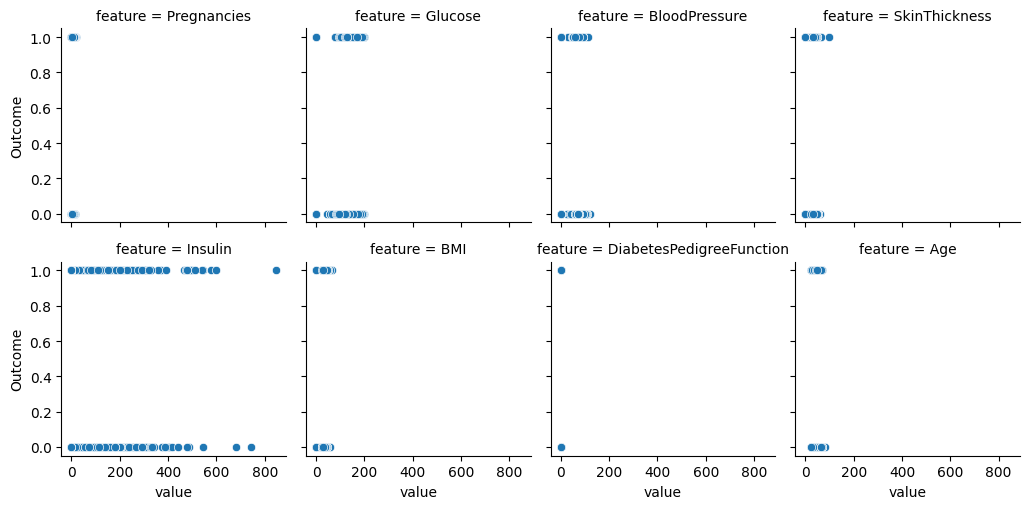

In [52]:
#Check for normality with scatter plot
list_independents = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

independent = [dataset['Pregnancies'], dataset['Glucose'], dataset['BloodPressure'], dataset['SkinThickness'], dataset['Insulin'], dataset['BMI'], dataset['DiabetesPedigreeFunction'], dataset['Age'] ]
dependent = np.array(dataset['Outcome'])

long = dataset.melt(id_vars ='Outcome', value_vars = list_independents, var_name ='feature', value_name ='value')
facet = sns.FacetGrid(long,col='feature',col_wrap=4,sharey=True,height=2.6)
facet.map_dataframe(sns.scatterplot, x='value',y='Outcome')
plt.show()

### Check and Visualize Outliers

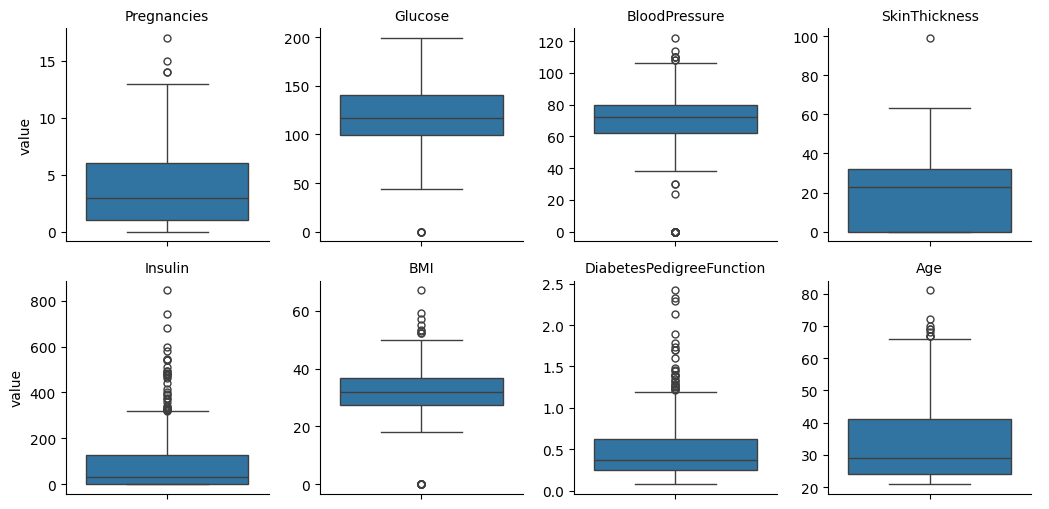

In [53]:
#Check for Outliers
long = dataset.melt(value_vars=list_independents, var_name='feature', value_name='value')

# 2) small multiples with separate y scales
g = sns.catplot(
    data=long, kind='box',
    y='value',                 # single-variable boxplot
    col='feature', col_wrap=4, # one facet per feature
    sharey=False,              # <-- separate y-scales
    height=2.6, aspect=1,
    showfliers=True
)

g.set_axis_labels("", "value")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()

In [54]:
#We recognized that SkinThickness, BMI, BloodPressure, and Glucose all had values of "0" that were substitutions for missing data as these values couldn't possibly be 0

cant_zero = ['SkinThickness', 'BMI', 'BloodPressure','Glucose','Insulin']

match 2:

  case 1:
    #Missing  = np.na
    dataset['Glucose'] = dataset['Glucose'].replace({0:np.nan})
    dataset['BloodPressure'] = dataset['BloodPressure'].replace({0:np.nan})
    dataset['SkinThickness'] = dataset['SkinThickness'].replace({0:np.nan})
    dataset['BMI'] = dataset['BMI'].replace({0:np.nan})
    dataset['Insulin'] = dataset['Insulin'].replace({0:np.nan})

  case 2:
       #missing = mean of that column
    for col in range(len(cant_zero)):
      col_name = cant_zero[col]
      col_mean = dataset[col_name].mean()
      dataset[col_name] = dataset[col_name].replace({0:col_mean})


#We hesitated on this one because it's technically possible to have 0 Insulin, but when seeing the scatterplot for insulin it's too drastic of a drop to 0
#Upon doing research we got mixed answers for if Insulin could equal 0, this difference was dependent on the type of diabetes between type 1 and type 2 which we sadly didn't have access to.

In [55]:
# Creating heatmap
def plot_correlation_heatmap(df, y, correlMapType):
    correlation = df.corr(method='spearman')
    # Get absolute correlations with the target (assume first column is target)
    target_col = y
    abs_corr = correlation[target_col].abs().sort_values(ascending=False)
    # Reorder the correlation matrix rows/columns by sorted absolute correlation
    sorted_cols = abs_corr.index.tolist()
    correlation = correlation.loc[sorted_cols, sorted_cols]
    plt.figure(figsize=(12, 8))
    cmap_type = correlMapType
    match cmap_type: #For this to work make sure to run: from matplotlib.colors import LinearSegmentedColormap
        case 0:
            colorMap = LinearSegmentedColormap.from_list("red_purple_blue_purple_red", ["red", "purple", "blue", "purple", "red"])
        case 1:
            colorMap = LinearSegmentedColormap.from_list("green_orange_red_orange_green", ["green", "orange", "red", "orange", "green"])
        case 2:
            colorMap = LinearSegmentedColormap.from_list("exaggerated_orange_mid", ["darkgreen","green","darkorange","orange","red","orange","darkorange","green","darkgreen"])
        case 3:
            colorMap = LinearSegmentedColormap.from_list("blend", ["gold","orange","red","orange","gold"])
    sns.heatmap(correlation, annot=True, cmap=colorMap, fmt=".2f", vmin=-1, vmax=1, center=0)

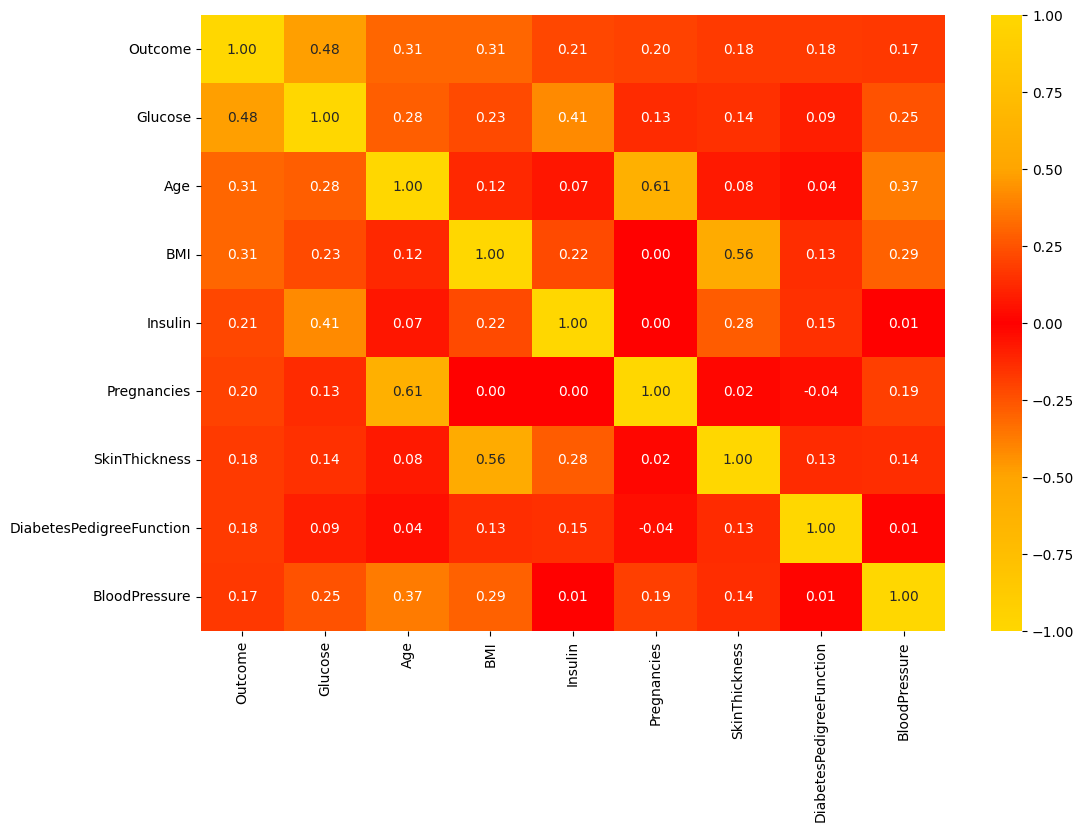

In [56]:
plot_correlation_heatmap(dataset, 'Outcome', 3)

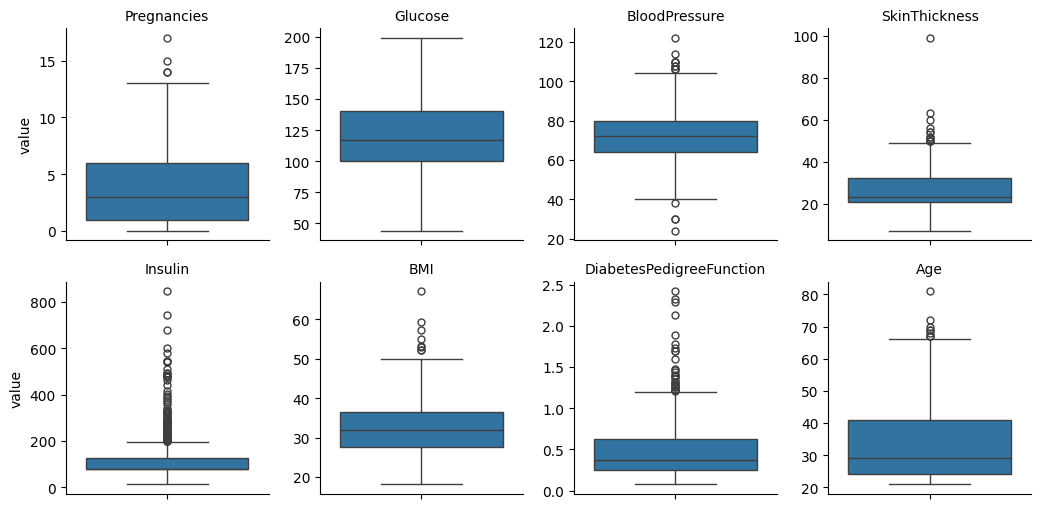

In [57]:
#Check for Outliers
long = dataset.melt(value_vars=list_independents, var_name='feature', value_name='value')

# 2) small multiples with separate y scales
g = sns.catplot(
    data=long, kind='box',
    y='value',                 # single-variable boxplot
    col='feature', col_wrap=4, # one facet per feature
    sharey=False,              # <-- separate y-scales
    height=2.6, aspect=1,
    showfliers=True
)

g.set_axis_labels("", "value")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()

In [58]:
#Test if each explanatory variable is statistically significant with Output
independent_name = ['Pregnancies','Glucose','BloodPressure', 'SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']
dependent_name = ['Outcome']
significant = fm.wald_significance_multivariate(dataset[independent_name],dataset[dependent_name], alpha=0.05)[0]
print(significant)


['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction']


In [59]:
for col in dataset.columns[:-1]:
  print(f"{col}: {dataset[col].quantile(1)}")

def IQRRange(x):
  q3 = x.quantile(0.75)
  q1 = x.quantile(0.25)
  iqr = q3 - q1
  mean = float(x.mean())
  upper_fence = q3+(3*iqr)
  lower_fence = q1-(3*iqr)
  return [lower_fence,upper_fence,mean]

Pregnancies: 17.0
Glucose: 199.0
BloodPressure: 122.0
SkinThickness: 99.0
Insulin: 846.0
BMI: 67.1
DiabetesPedigreeFunction: 2.42
Age: 81.0


In [60]:
# Remove all outliers exceeding >q3+(3*iqr) and <q1-(3*iqr)
for col in range(dataset.shape[1]):
  col_name = dataset.columns[col]
  col_mean = dataset[col_name].mean()
  lower_fence, upper_fence,__ = IQRRange(dataset[col_name])
  dataset.loc[
    (dataset[col_name] > upper_fence) |
    (dataset[col_name] < lower_fence) ,
    col_name
  ] = float(col_mean)

pd.set_option("display.max_rows",40)
dataset.head(40)

/tmp/ipython-input-214467369.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.8450520833333335' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[
/tmp/ipython-input-214467369.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '33.240885416666664' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[
/tmp/ipython-input-214467369.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3489583333333333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.000000,35.000000,79.799479,33.600000,0.627000,50.0,1.0
1,1.0,85.0,66.000000,29.000000,79.799479,26.600000,0.351000,31.0,0.0
2,8.0,183.0,64.000000,20.536458,79.799479,23.300000,0.672000,32.0,1.0
3,1.0,89.0,66.000000,23.000000,94.000000,28.100000,0.167000,21.0,0.0
4,0.0,137.0,40.000000,35.000000,168.000000,43.100000,0.471876,33.0,1.0
5,5.0,116.0,74.000000,20.536458,79.799479,25.600000,0.201000,30.0,0.0
6,3.0,78.0,50.000000,32.000000,88.000000,31.000000,0.248000,26.0,1.0
7,10.0,115.0,69.105469,20.536458,79.799479,35.300000,0.134000,29.0,0.0
8,2.0,197.0,70.000000,45.000000,118.660163,30.500000,0.158000,53.0,1.0
9,8.0,125.0,96.000000,20.536458,79.799479,31.992578,0.232000,54.0,1.0


In [61]:
#remove row overfill
pd.set_option("display.max_rows",10)

In [62]:
#Test if each explanatory variable is statistically significant with Output
independent_name = ['Pregnancies','Glucose','BloodPressure', 'SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']
dependent_name = ['Outcome']
significant = fm.wald_significance_multivariate(dataset[independent_name],dataset[dependent_name], alpha=0.05)[0]
significant.append('Insulin')
print(significant)

['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Insulin']


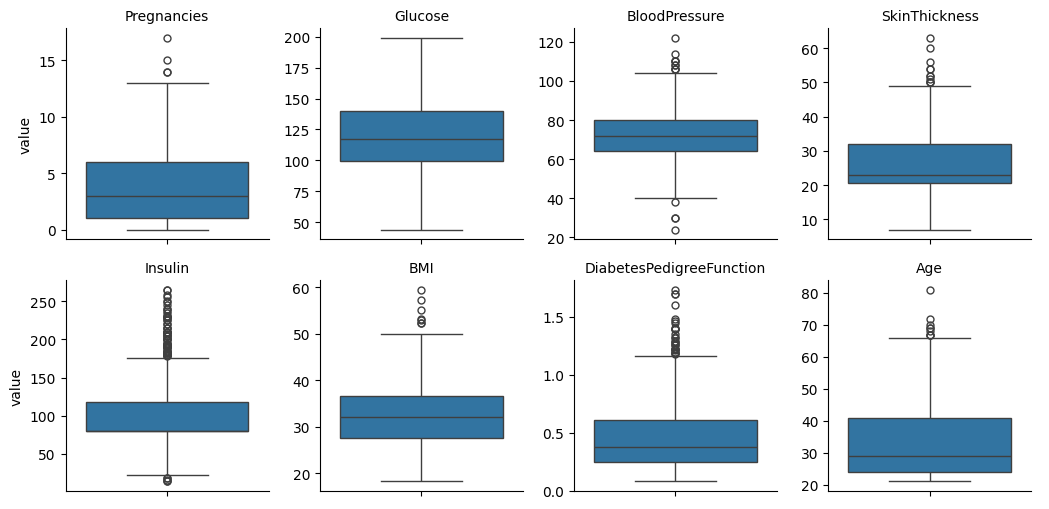

In [63]:
#Check for Outliers
long = dataset.melt(value_vars=list_independents, var_name='feature', value_name='value')

# 2) small multiples with separate y scales
g = sns.catplot(
    data=long, kind='box',
    y='value',                 # single-variable boxplot
    col='feature', col_wrap=4, # one facet per feature
    sharey=False,              # <-- separate y-scales
    height=2.6, aspect=1,
    showfliers=True
)

g.set_axis_labels("", "value")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()

In [64]:
#Since DiabetesPedigreeFunction has the most we will start removing its outliers next
#dataset_insulin_adj.describe()

# Logistic Regression Model

<Axes: xlabel='Outcome', ylabel='count'>

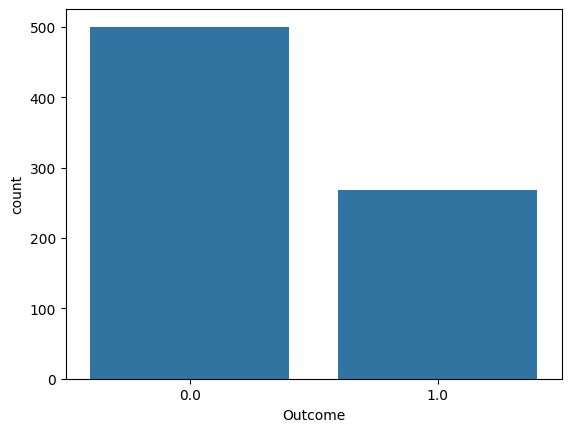

In [65]:
sns.countplot(x='Outcome',data=dataset)

In [66]:
x = dataset[significant]
y = dataset['Outcome']
significant

['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Insulin']

In [67]:
iterator = 0
score_array = np.array([],dtype=float)
while iterator < 100:
  x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=rand.randint(0,1000))
  model = LogisticRegression(multi_class="multinomial", solver="lbfgs")
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  model.score(x_test, y_test)
  score_array = np.append(score_array, model.score(x_test, y_test))
  iterator += 1

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' w

In [68]:
print(x_train.shape,
      x_test.shape)

(614, 5) (154, 5)


In [69]:
print(f"Score Average (100 cycles): {np.mean(score_array)}\n")
print(score_array)

Score Average (100 cycles): 0.764155844155844

[0.76623377 0.76623377 0.80519481 0.76623377 0.81168831 0.81818182
 0.77922078 0.77922078 0.77922078 0.81168831 0.7987013  0.77272727
 0.75324675 0.75324675 0.75974026 0.76623377 0.78571429 0.73376623
 0.83116883 0.73376623 0.74025974 0.77272727 0.76623377 0.78571429
 0.81818182 0.77272727 0.75324675 0.68831169 0.76623377 0.79220779
 0.74025974 0.79220779 0.75324675 0.79220779 0.75974026 0.78571429
 0.75324675 0.72077922 0.72077922 0.77272727 0.77272727 0.75974026
 0.71428571 0.77922078 0.74675325 0.77272727 0.72077922 0.75974026
 0.75324675 0.70779221 0.79220779 0.76623377 0.7987013  0.77922078
 0.76623377 0.76623377 0.74675325 0.78571429 0.74675325 0.73376623
 0.76623377 0.75974026 0.75974026 0.76623377 0.74675325 0.76623377
 0.73376623 0.77922078 0.73376623 0.71428571 0.72727273 0.72077922
 0.70779221 0.74025974 0.81168831 0.77272727 0.80519481 0.75324675
 0.74675325 0.79220779 0.79220779 0.77272727 0.72077922 0.73376623
 0.78571429 0.7

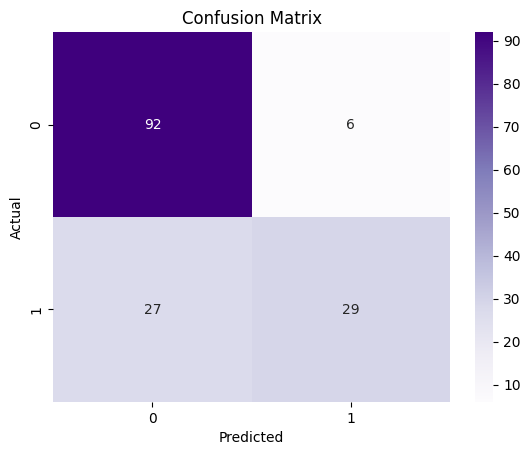

In [70]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Purples", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.94      0.85        98
         1.0       0.83      0.52      0.64        56

    accuracy                           0.79       154
   macro avg       0.80      0.73      0.74       154
weighted avg       0.79      0.79      0.77       154



> Our model on average is 77% accurate in predicting diabetes of females who are least 21 years old of Pima Indian heritage.

# Trying to improve Recall

## Bootstrapping

In [72]:
x_boot, y_boot = resample(x, y, replace=True)

x_train, x_test, y_train, y_test = train_test_split(x_boot, y_boot, test_size=0.2, stratify=y_boot)

model = LogisticRegression(solver="lbfgs", max_iter=1000, class_weight="balanced")
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.77      0.80        96
         1.0       0.66      0.72      0.69        58

    accuracy                           0.75       154
   macro avg       0.74      0.75      0.74       154
weighted avg       0.76      0.75      0.76       154



## K-Fold

In [73]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

model = LogisticRegression(solver="lbfgs", max_iter=1000, class_weight="balanced")
model.fit(x.iloc[train_idx], y.iloc[train_idx])
y_pred = model.predict(x.iloc[test_idx])

print(classification_report(y.iloc[test_idx], y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.70      0.74        50
         1.0       0.52      0.62      0.56        26

    accuracy                           0.67        76
   macro avg       0.65      0.66      0.65        76
weighted avg       0.69      0.67      0.68        76



## Leave One Out Cross Validation (LOOCV)

In [79]:
loo = LeaveOneOut()

y_true = []
y_pred_all = []

for train_idx, test_idx in loo.split(x):
    model = LogisticRegression(solver="lbfgs", max_iter=1000, class_weight="balanced")
    model.fit(x.iloc[train_idx], y.iloc[train_idx])

    y_pred = model.predict(x.iloc[test_idx])

    y_true.append(y.iloc[test_idx].values[0])
    y_pred_all.append(y_pred[0])

print(classification_report(y_true, y_pred_all))

              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81       500
         1.0       0.64      0.72      0.68       268

    accuracy                           0.76       768
   macro avg       0.74      0.75      0.75       768
weighted avg       0.77      0.76      0.77       768



## Threshold Tweaking

In [80]:
model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(x, y)

probs = model.predict_proba(x)[:, 1]

thresholds = [0.5, 0.45, 0.40, 0.35, 0.30, 0.25]

for t in thresholds:
    preds = (probs >= t).astype(int)
    print(f"Threshold: {t}")
    print(classification_report(y, preds))

Threshold: 0.5
              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81       500
         1.0       0.64      0.73      0.68       268

    accuracy                           0.76       768
   macro avg       0.74      0.76      0.75       768
weighted avg       0.77      0.76      0.77       768

Threshold: 0.45
              precision    recall  f1-score   support

         0.0       0.87      0.74      0.80       500
         1.0       0.62      0.78      0.69       268

    accuracy                           0.76       768
   macro avg       0.74      0.76      0.75       768
weighted avg       0.78      0.76      0.76       768

Threshold: 0.4
              precision    recall  f1-score   support

         0.0       0.88      0.68      0.76       500
         1.0       0.58      0.83      0.68       268

    accuracy                           0.73       768
   macro avg       0.73      0.75      0.72       768
weighted avg       0.77     

> Threshold tweaking seems to be the most promising at improving recall (at least for this dataset) since it was able to get it in the >0.9 range